# Setting up the environment


In [12]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [13]:
# download spark3.0.0
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
print("success!")

success!


In [14]:
# unzip it
!tar xf spark-3.3.1-bin-hadoop3.tgz


In [15]:
# install findspark 
!pip install -q findspark

In [16]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

Testing the setup

In [17]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Test the spark
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])
df.show(3, False)

+-----+
|hello|
+-----+
|world|
|world|
|world|
+-----+
only showing top 3 rows



In [18]:
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt

In [19]:
matches_df= spark.read.csv("/content/drive/MyDrive/Task4/Matches.csv",header = True, inferSchema=True)

In [20]:
matches_df.show(5)

+--------+---+------+-------------------+-------------+--------------+----+----+---+
|Match_ID|Div|Season|               Date|     HomeTeam|      AwayTeam|FTHG|FTAG|FTR|
+--------+---+------+-------------------+-------------+--------------+----+----+---+
|       1| D2|  2009|2010-04-04 00:00:00|   Oberhausen|Kaiserslautern|   2|   1|  H|
|       2| D2|  2009|2009-11-01 00:00:00|  Munich 1860|Kaiserslautern|   0|   1|  A|
|       3| D2|  2009|2009-10-04 00:00:00|Frankfurt FSV|Kaiserslautern|   1|   1|  D|
|       4| D2|  2009|2010-02-21 00:00:00|Frankfurt FSV|     Karlsruhe|   2|   1|  H|
|       5| D2|  2009|2009-12-06 00:00:00|        Ahlen|     Karlsruhe|   1|   3|  A|
+--------+---+------+-------------------+-------------+--------------+----+----+---+
only showing top 5 rows



Renaming some Columns to make them easy to read and understand.

In [21]:
old_cols= matches_df.columns[-3:]
new_cols  =["hometeamgoals", "awayteamgoals", "finalresult"]
old_new_cols = [*zip(old_cols, new_cols)]
for old_col, new_col in old_new_cols:
  matches_df = matches_df.withColumnRenamed(old_col, new_col)

matches_df.show(5)

+--------+---+------+-------------------+-------------+--------------+-------------+-------------+-----------+
|Match_ID|Div|Season|               Date|     HomeTeam|      AwayTeam|hometeamgoals|awayteamgoals|finalresult|
+--------+---+------+-------------------+-------------+--------------+-------------+-------------+-----------+
|       1| D2|  2009|2010-04-04 00:00:00|   Oberhausen|Kaiserslautern|            2|            1|          H|
|       2| D2|  2009|2009-11-01 00:00:00|  Munich 1860|Kaiserslautern|            0|            1|          A|
|       3| D2|  2009|2009-10-04 00:00:00|Frankfurt FSV|Kaiserslautern|            1|            1|          D|
|       4| D2|  2009|2010-02-21 00:00:00|Frankfurt FSV|     Karlsruhe|            2|            1|          H|
|       5| D2|  2009|2009-12-06 00:00:00|        Ahlen|     Karlsruhe|            1|            3|          A|
+--------+---+------+-------------------+-------------+--------------+-------------+-------------+-----------+
o

# Answering Questions

## Q1- Who are the winners of the D1 division in the Germany Football Association (Bundesliga) between 2000-2010?


In [22]:
matches_df = matches_df \
    .withColumn('hometeamwin', when(col('finalresult') == 'H', 1).otherwise(0)) \
    .withColumn('awayteamwin', when(col('finalresult') == 'A', 1).otherwise(0)) \
    .withColumn('gametie', when(col('finalresult') == 'D', 1).otherwise(0))

D1division = matches_df \
                    .filter((col('Season')>=2000)&
                            (col('Season')<=2010)&
                            (col('Div')=='D1'))


home1 = D1division.groupby('Season', 'HomeTeam') \
        .agg(sum('hometeamwin').alias('totalhomewin'),
             sum('awayteamwin').alias('totalhomeloss'),
             sum('gametie').alias('totalhometie'),
             sum('hometeamgoals').alias('homescoredgoals'),
             sum('awayteamgoals').alias('homeagainstgoals')) \
        .withColumnRenamed('HomeTeam', 'team')

away1 = D1division.groupby('Season', 'AwayTeam') \
        .agg(sum('awayteamwin').alias('totalawaywin'),
             sum('hometeamwin').alias('totalawayloss'),
             sum('gametie').alias('totalawaytie'),
             sum('awayteamgoals').alias('awayscoredgoals'),
             sum('hometeamgoals').alias('awayagainstgoals')) \
        .withColumnRenamed('AwayTeam', 'team')

In [23]:
home1.show(5)

+------+-------------+------------+-------------+------------+---------------+----------------+
|Season|         team|totalhomewin|totalhomeloss|totalhometie|homescoredgoals|homeagainstgoals|
+------+-------------+------------+-------------+------------+---------------+----------------+
|  2005|Bayern Munich|          14|            1|           2|             42|              14|
|  2008|   M'gladbach|           5|            8|           4|             23|              27|
|  2006|      Cottbus|           6|            6|           5|             21|              22|
|  2010|     Hannover|          12|            4|           1|             32|              17|
|  2004|   Leverkusen|          12|            2|           3|             42|              18|
+------+-------------+------------+-------------+------------+---------------+----------------+
only showing top 5 rows



In [24]:
away1.show(5)

+------+-------------+------------+-------------+------------+---------------+----------------+
|Season|         team|totalawaywin|totalawayloss|totalawaytie|awayscoredgoals|awayagainstgoals|
+------+-------------+------------+-------------+------------+---------------+----------------+
|  2005|Bayern Munich|           8|            2|           7|             25|              18|
|  2008|   M'gladbach|           3|           11|           3|             16|              35|
|  2006|      Cottbus|           5|            9|           3|             17|              27|
|  2010|     Hannover|           7|            8|           2|             17|              28|
|  2004|   Leverkusen|           4|            7|           6|             23|              26|
+------+-------------+------------+-------------+------------+---------------+----------------+
only showing top 5 rows



In [25]:
#season features
window=['Season']
window = Window.partitionBy(window).orderBy(col('winpct').desc(), col('goaldifferentials').desc())
tabledetails2010 = home1.join(away1,['Team', 'Season'],'inner') \
    .withColumn('goalsscored', col('homescoredgoals')+ col('awayscoredgoals')) \
    .withColumn('goalsagainst', col('homeagainstgoals')+col('awayagainstgoals')) \
    .withColumn('goaldifferentials', col('goalsscored')-col('goalsagainst')) \
    .withColumn('win', col('totalhomewin')+col('totalawaywin')) \
    .withColumn('loss', col('totalhomeloss')+col('totalawayloss')) \
    .withColumn('tie', col('totalhometie')+col('totalawaytie')) \
    .withColumn('winpct', round((100*col('win')/(col('win')+col('loss')+ col('tie'))),2)) \
    .drop('homescoredgoals', 'awayscoredgoals', 'homeagainstgoals', 'awayagainstgoals') \
    .drop('totalhomewin','totalawaywins', 'totalhomeloss','totalawayloss','totalhometie','totalawaytie') \
    .withColumn('teamposition', rank().over(window))

tabledetails2010_df= tabledetails2010.filter(col('teamposition')==1).orderBy(desc('Season')).toPandas()
tabledetails2010_df


,team,Season,totalawaywin,goalsscored,goalsagainst,goaldifferentials,win,loss,tie,winpct,teamposition
0,Dortmund,2010,11,67,22,45,23,5,6,67.65,1
1,Bayern Munich,2009,8,72,31,41,20,4,10,58.82,1
2,Wolfsburg,2008,5,80,41,39,21,7,6,61.76,1
3,Bayern Munich,2007,10,68,21,47,22,2,10,64.71,1
4,Stuttgart,2006,9,61,37,24,21,6,7,61.76,1
5,Bayern Munich,2005,8,67,32,35,22,3,9,64.71,1
6,Bayern Munich,2004,10,75,33,42,24,5,5,70.59,1
7,Werder Bremen,2003,11,79,38,41,22,4,8,64.71,1
8,Bayern Munich,2002,10,70,25,45,23,5,6,67.65,1
9,Leverkusen,2001,7,77,38,39,21,7,6,61.76,1


Bayern Munich won 6 times in D1 division between 2000-2010 in German Football association.

## Q2. Which teams have been relegated in the past 10 years?

So to get the teams which have been relegated, we need to calculate each teams total points and rank then in ascending order.
The official condition of assigning points is that


*   Winning team gets 3 points
*   Losing team gets 0 points
*   Game tie then both teams get 1 point each

In [26]:
lastdecadebundesliga= matches_df.filter((col('Season')>=2007)&
                                        (col('Season')<=2017)&
                                        (col('Div')=='D1'))

home2 = lastdecadebundesliga.groupby('Season', 'HomeTeam') \
        .agg(sum('hometeamwin').alias('totalhomewin'),
             sum('awayteamwin').alias('totalhomeloss'),
             sum('gametie').alias('totalhometie'),
             sum('hometeamgoals').alias('homescoredgoals'),
             sum('awayteamgoals').alias('homeagainstgoals')) \
        .withColumnRenamed('HomeTeam', 'team')

away2 = lastdecadebundesliga.groupby('Season', 'AwayTeam') \
        .agg(sum('awayteamwin').alias('totalawaywin'),
             sum('hometeamwin').alias('totalawayloss'),
             sum('gametie').alias('totalawaytie'),
             sum('awayteamgoals').alias('awayscoredgoals'),
             sum('hometeamgoals').alias('awayagainstgoals')) \
        .withColumnRenamed('AwayTeam', 'team')

In [27]:
home2.sort('Season').toPandas()

,Season,team,totalhomewin,totalhomeloss,totalhometie,homescoredgoals,homeagainstgoals
0,2007,Cottbus,8,7,2,25,20
1,2007,Bayern Munich,12,0,5,41,8
2,2007,Hannover,8,4,5,32,27
3,2007,Bielefeld,7,6,4,21,18
4,2007,Duisburg,3,11,3,19,29
...,...,...,...,...,...,...,...
193,2017,Schalke 04,17,0,0,-17,-17
194,2017,Ein Frankfurt,17,0,0,-17,-17
195,2017,Stuttgart,17,0,0,-17,-17
196,2017,Mainz,17,0,0,-17,-17


In [28]:
away2.sort('Season').toPandas()

,Season,team,totalawaywin,totalawayloss,totalawaytie,awayscoredgoals,awayagainstgoals
0,2007,Cottbus,1,9,7,10,36
1,2007,Bayern Munich,10,2,5,27,13
2,2007,Hannover,5,7,5,22,29
3,2007,Bielefeld,1,10,6,14,42
4,2007,Duisburg,5,10,2,17,26
...,...,...,...,...,...,...,...
193,2017,Ein Frankfurt,0,17,0,-17,-17
194,2017,Schalke 04,0,17,0,-17,-17
195,2017,Stuttgart,0,17,0,-17,-17
196,2017,Mainz,0,17,0,-17,-17


In [29]:
window=['Season']
window = Window.partitionBy('Season').orderBy(col('totalpoints').desc(), col('goaldifferentials'))

team_details = home2.join(away2, ['Season', 'Team'], 'inner') \
            .withColumn('goalsscored', col('homescoredgoals')+col('awayscoredgoals')) \
            .withColumn('goalsagainst', col('homeagainstgoals')+col('awayagainstgoals')) \
            .withColumn('goaldifferentials', col('goalsscored')-col('goalsagainst')) \
            .withColumn('win', col('totalhomewin')+col('totalawaywin')) \
            .withColumn('loss', col('totalhomeloss')+col('totalawayloss')) \
            .withColumn('tie', col('totalhometie')+col('totalawaytie')) \
            .withColumn('totalpoints', col('win')*3+col('tie')) \
            .withColumn('goalsscored', col('homescoredgoals')+col('awayscoredgoals')) \
            .withColumn('goalsscored', col('homescoredgoals')+col('awayscoredgoals')) \
            .drop('homescoredgoals', 'homeagainstgoals','awayscoredgoals', 'awayagainstgoals') \
            .drop('totalhomewin', 'totalawaywin', 'totalhomeloss', 'totalawayloss','totalagainstloss', 'totalhometie', 'totalawaytie') \
            .withColumn('teamposition', rank().over(window))

team_details_df = team_details.filter((col('teamposition')>=17)).orderBy(asc('Season')).toPandas()
team_details_df

            

,Season,team,goalsscored,goalsagainst,goaldifferentials,win,loss,tie,totalpoints,teamposition
0,2007,Hansa Rostock,30,52,-22,8,20,6,30,17
1,2007,Duisburg,36,55,-19,8,21,5,29,18
2,2008,Karlsruhe,30,54,-24,8,21,5,29,17
3,2008,Bielefeld,29,56,-27,4,14,16,28,18
4,2009,Bochum,33,64,-31,6,18,10,28,17
5,2009,Hertha,34,56,-22,5,20,9,24,18
6,2010,Ein Frankfurt,31,49,-18,9,18,7,34,17
7,2010,St Pauli,35,68,-33,8,21,5,29,18
8,2011,FC Koln,39,75,-36,8,20,6,30,17
9,2011,Kaiserslautern,24,54,-30,4,19,11,23,18


These teams were relegated in the last decade(2007-2017).

## Q3. Does octoberfest affect the performance of Bundesliga?

In [30]:
from pyspark.sql.functions import udf
def months(month):
    swap = {
        1: 'January',
        2: 'February',
        3: 'March',
        4: 'April',
        5: 'May',
        6: 'June',
        7: 'July',
        8: 'August',
        9: 'September',
        10: 'October',
        11: 'November',
        12: 'December'
    }

    return swap.get(month, 'invalid month')

month_udf = udf(months)
bundesliga_monthly_table= lastdecadebundesliga.withColumn('monthnum', month('Date')) \
                                        .withColumn('month', month_udf(col('monthnum')))

bundesliga_monthly_table.toPandas()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,hometeamgoals,awayteamgoals,finalresult,hometeamwin,awayteamwin,gametie,monthnum,month
0,21,D1,2009,2010-02-06,Bochum,Leverkusen,1,1,D,0,0,1,2,February
1,22,D1,2009,2009-11-22,Bayern Munich,Leverkusen,1,1,D,0,0,1,11,November
2,23,D1,2009,2010-05-08,M'gladbach,Leverkusen,1,1,D,0,0,1,5,May
3,24,D1,2009,2009-08-08,Mainz,Leverkusen,2,2,D,0,0,1,8,August
4,25,D1,2009,2009-10-17,Hamburg,Leverkusen,0,0,D,0,0,1,10,October
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3361,7905,D1,2009,2010-02-06,FC Koln,Hamburg,3,3,D,0,0,1,2,February
3362,7906,D1,2009,2010-05-08,Werder Bremen,Hamburg,1,1,D,0,0,1,5,May
3363,7907,D1,2009,2010-02-13,Stuttgart,Hamburg,1,3,A,0,1,0,2,February
3364,7908,D1,2009,2010-02-28,Bayern Munich,Hamburg,1,0,H,1,0,0,2,February


I am going to compare monthly performance on basis of goals per month.
So if goals per month significantly vary, that means the performance were affected by octoberfest.
Also octoberfest happens from september 16th to october 3rd.

In [31]:
bundesliga_monthly_results= bundesliga_monthly_table.groupBy('Season', 'month', 'monthnum') \
                                              .agg(sum('hometeamgoals').alias('homegoals'),
                                                   sum('awayteamgoals').alias('awaygoals'))
                                              
bundesliga_monthly_results = bundesliga_monthly_results \
                                .withColumn('goals', col('homegoals')+ col('awaygoals')) \
                                .sort('Season', 'monthnum') \
                                .drop('homegoals', 'awaygoals','monthnum')
bundesliga_monthly_results.toPandas()


,Season,month,goals
0,2007,February,103
1,2007,March,106
2,2007,April,101
3,2007,May,119
4,2007,August,75
...,...,...,...
104,2017,August,-36
105,2017,September,-72
106,2017,October,-72
107,2017,November,-54


We'll compare seasons 2013, 2014, 2015, and 2016.

In [32]:
bundesliga_monthly_2013= bundesliga_monthly_results \
                            .filter(col('Season') ==2013)
bundesliga_monthly_2014= bundesliga_monthly_results \
                            .filter(col('Season') ==2014)
bundesliga_monthly_2015= bundesliga_monthly_results \
                            .filter(col('Season') ==2015)
bundesliga_monthly_2016= bundesliga_monthly_results \
                            .filter(col('Season') ==2016)



In [33]:
def plotbundesligamonthly(labels,year,df_goals):
  fig = plt.figure(figsize=(12, 4))
  # grid = plt.GridSpec(2, 1, hspace=.2)
  ax_goals = plt.subplot()
  ax_goals.set_ylabel('Goals')
  ax_goals.set_title(f'Goals scored in {year}')
  ax2= df_goals.plot('month', 'goals', kind = 'bar',color= 'green', ax = ax_goals)
  fig = plt.show()

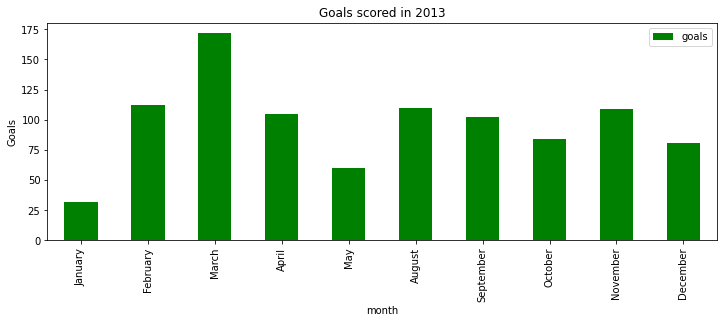

In [34]:
plotbundesligamonthly(bundesliga_monthly_2013.toPandas()['month'],
                      2013,
                      bundesliga_monthly_2013.toPandas())

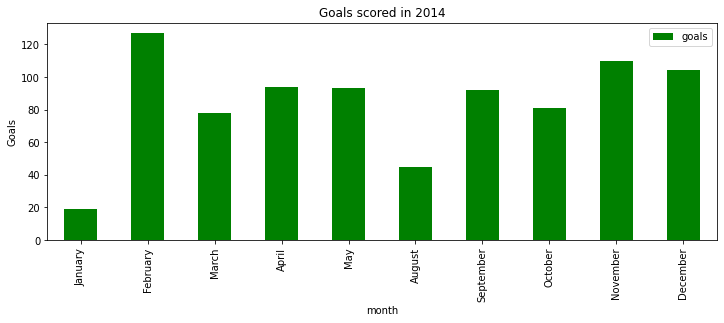

In [35]:
plotbundesligamonthly(bundesliga_monthly_2014.toPandas()['month'],
                      2014,
                      bundesliga_monthly_2014.toPandas())

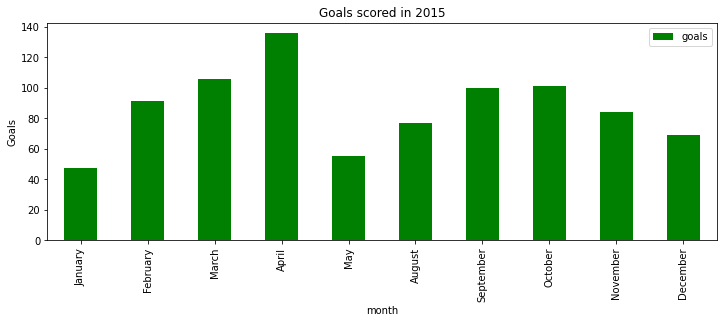

In [36]:
plotbundesligamonthly(bundesliga_monthly_2015.toPandas()['month'],
                      2015,
                      bundesliga_monthly_2015.toPandas())

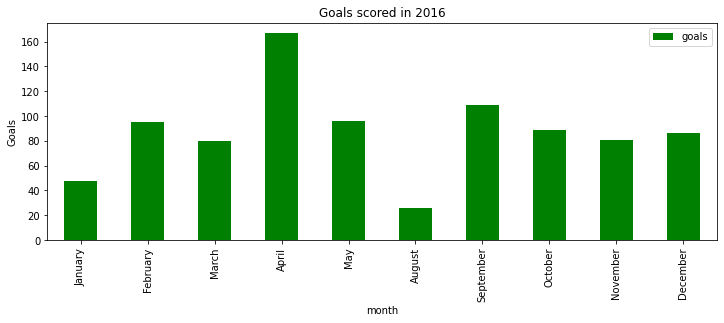

In [37]:
plotbundesligamonthly(bundesliga_monthly_2016.toPandas()['month'],
                      2016,
                      bundesliga_monthly_2016.toPandas())

It is concluded that octoberfest doesn't affect bundesliga performance, there is no significantly behavior change in goals scored.

## Q4. Which season of bundesliga was the most competitive in the last decade?

In [38]:
#using team_details from Q2
teamposition1= team_details.filter((col('teamposition')==1))
teamposition2= team_details.filter((col('teamposition')==2))
teamposition3= team_details.filter((col('teamposition')==3))
teamposition4= team_details.filter((col('teamposition')==4))
teamposition1.toPandas()

,Season,team,goalsscored,goalsagainst,goaldifferentials,win,loss,tie,totalpoints,teamposition
0,2007,Bayern Munich,68,21,47,22,2,10,76,1
1,2008,Wolfsburg,80,41,39,21,7,6,69,1
2,2009,Bayern Munich,72,31,41,20,4,10,70,1
3,2010,Dortmund,67,22,45,23,5,6,75,1
4,2011,Dortmund,80,25,55,25,3,6,81,1
5,2012,Bayern Munich,98,18,80,29,1,4,91,1
6,2013,Bayern Munich,94,23,71,29,2,3,90,1
7,2014,Bayern Munich,80,18,62,25,5,4,79,1
8,2015,Bayern Munich,80,17,63,28,2,4,88,1
9,2016,Bayern Munich,89,22,67,25,2,7,82,1


In [39]:
competition_table= teamposition1.alias('first').join(teamposition2.alias('second'), 'Season', how = 'inner') \
                      .join(teamposition3.alias('third'), 'Season', how= 'inner') \
                      .join(teamposition4.alias('fourth'), 'Season', how='inner') \
                      .withColumn('winner', col('first.team')) \
                      .withColumn('pointsdiff_1-2', col('first.totalpoints')- col('second.totalpoints')) \
                      .withColumn('pointsdiff_1-3', col('first.totalpoints')- col('third.totalpoints')) \
                      .withColumn('pointsdiff_1-4', col('first.totalpoints')- col('fourth.totalpoints')) \
                      .drop('goalsscored', 'goalsagainst', 'goaldifferentials', 'win', 'loss', 'tie') \
                      .drop('team', 'teamposition', 'totalpoints')

                      
competition_table.sort(['pointsdiff_1-2', 'pointsdiff_1-3', 'pointsdiff_1-4']).toPandas()


,Season,winner,pointsdiff_1-2,pointsdiff_1-3,pointsdiff_1-4
0,2008,Wolfsburg,2,5,6
1,2009,Bayern Munich,5,9,11
2,2010,Dortmund,7,10,15
3,2011,Dortmund,8,17,21
4,2007,Bayern Munich,10,12,22
5,2014,Bayern Munich,10,13,18
6,2015,Bayern Munich,10,28,33
7,2016,Bayern Munich,15,18,20
8,2013,Bayern Munich,19,26,29
9,2012,Bayern Munich,25,26,36


The most competitive season of bundesliga in last decade was 2008. In 2008 Wolfsburg was champion by a 2 points lead from second place.

## Q5. What's the best month to watch Bundesliga?

In [40]:
bundesliga_monthly= bundesliga_monthly_table.groupBy('Season', 'month', 'monthnum') \
                                              .agg(sum('hometeamgoals').alias('homegoals'),
                                                   sum('awayteamgoals').alias('awaygoals'),
                                                   sum('gametie').alias('ties'),
                                                   sum('hometeamwin').alias('hometeamwin'),
                                                   sum('awayteamwin').alias('awayteamwin'))
                                                           
bundesliga_monthly = bundesliga_monthly \
                                .withColumn('not_tie', col('hometeamwin')+col('awayteamwin')) \
                                .withColumn('goals', col('homegoals')+ col('awaygoals')) \
                                .sort('Season', 'monthnum') \
                                .drop('homegoals', 'awaygoals','monthnum', 'hometeamwin', 'awayteamwin')
bundesliga_monthly.toPandas()

,Season,month,ties,not_tie,goals
0,2007,February,11,26,103
1,2007,March,18,26,106
2,2007,April,8,28,101
3,2007,May,6,30,119
4,2007,August,6,22,75
...,...,...,...,...,...
104,2017,August,0,18,-36
105,2017,September,0,36,-72
106,2017,October,0,36,-72
107,2017,November,0,27,-54


In [41]:
window = Window.partitionBy('Season').orderBy(col('goalspermatch').desc())

best_month_df = bundesliga_monthly \
                  .filter((col('Season')>=2006)& (col('Season')<=2016)) \
                  .withColumn('goalspermatch', col('goals')/(col('ties')+col('not_tie'))) \
                  .withColumn('rankgoalspermatch',rank().over(window))

best_month_df = best_month_df.sort('Season', 'goalspermatch', ascending=False)
best_month_df.toPandas()

,Season,month,ties,not_tie,goals,goalspermatch,rankgoalspermatch
0,2016,May,12,15,96,3.555556,1
1,2016,April,10,43,167,3.150943,2
2,2016,November,7,20,81,3.000000,3
3,2016,September,8,29,109,2.945946,4
4,2016,August,2,7,26,2.888889,5
...,...,...,...,...,...,...,...
94,2007,April,8,28,101,2.805556,5
95,2007,February,11,26,103,2.783784,6
96,2007,August,6,22,75,2.678571,7
97,2007,March,18,26,106,2.409091,8


In [42]:
best_month_df.select('*').where((col('rankgoalspermatch')==1)) \
      .toPandas()

,Season,month,ties,not_tie,goals,goalspermatch,rankgoalspermatch
0,2016,May,12,15,96,3.555556,1
1,2015,April,9,35,136,3.090909,1
2,2014,November,3,32,110,3.142857,1
3,2013,September,8,21,102,3.517241,1
4,2012,May,8,19,92,3.407407,1
5,2011,May,0,9,35,3.888889,1
6,2010,August,1,17,67,3.722222,1
7,2009,December,10,17,82,3.037037,1
8,2008,September,5,21,84,3.230769,1
9,2007,May,6,30,119,3.305556,1


I would suggest that May is the best month to watch Bundesliga, because this month had most goals per match compared to other months in the years 2016, 2012, 2011, and 2007.  

Namaste :)